<a href="https://colab.research.google.com/github/duper203/upstage_cookbook/blob/main/Knowledge_Graphs_with_Structured_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Knowledge Graphs with LLMs and Structured Outputs
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Knowledge_Graphs_with_Structured_Outputs.ipynb)

## Introduction

In this notebook we show how to generate and visualize knowledge graphs using Large Language Models (LLMs), JSON mode for structured output generation. We will use [Together AI JSON mode](https://docs.together.ai/docs/json-mode) to access models that will generate JSON structures that represent a knowledge graph (including nodes, edges, labels) for us.

We will then pass these knowledge graph components to [GraphViz](https://graphviz.org/) that will help us generate and visualize these graphs.

<img src="https://github.com/togethercomputer/together-cookbook/blob/main/images/cluster.png?raw=1" height="500">

### Install relevant libraries

In [ ]:
!pip install -qU graphviz openai

In [5]:
import os, json
from google.colab import userdata
from openai import OpenAI # openai==1.2.0

os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")

## Define Knowledge Graph Schema in Pydantic

We need a way of telling the LLM what structure a knowledge graph has - including what information the nodes, edges must have and how they come together to create the overall graph structure. We will do this using `pydantic` models.

Below we define the required classes.

- Each node in our graph needs to have an `id` and a `label`. The `Node` class specifies this.
- Each edge in our graph needs to have a `label` and must also connect two nodes from the `source` to `destination` direction. The `Edge` class specified this.
- Each Knowledge graph is a combination of multiple `Node` and `Edge` elements. The `KnowledgeGraph` class specifies this.

In [6]:
from pydantic import BaseModel, Field
from typing import List

class Node(BaseModel, frozen=True):
    id: int
    label: str

class Edge(BaseModel, frozen=True):
    source: int
    target: int
    label: str

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)
    edges: List[Edge] = Field(..., default_factory=list)

In [7]:
# Print out the JSON Schema for our knowledge graph
KnowledgeGraph.model_json_schema()

{'$defs': {'Edge': {'properties': {'source': {'title': 'Source',
     'type': 'integer'},
    'target': {'title': 'Target', 'type': 'integer'},
    'label': {'title': 'Label', 'type': 'string'}},
   'required': ['source', 'target', 'label'],
   'title': 'Edge',
   'type': 'object'},
  'Node': {'properties': {'id': {'title': 'Id', 'type': 'integer'},
    'label': {'title': 'Label', 'type': 'string'}},
   'required': ['id', 'label'],
   'title': 'Node',
   'type': 'object'}},
 'properties': {'nodes': {'items': {'$ref': '#/$defs/Node'},
   'title': 'Nodes',
   'type': 'array'},
  'edges': {'items': {'$ref': '#/$defs/Edge'},
   'title': 'Edges',
   'type': 'array'}},
 'title': 'KnowledgeGraph',
 'type': 'object'}

## Function to Generate a Knowledge Graph using LLMs

Here we use Together AI to access `Meta-Llama-3.1-70B` in strict JSON mode. We pass in instructions to get the LLM to generate a knowledge that captures the information about a passed in `input` string.

We pass in the above `KnowledgeGraph` JSON schema to guide the structured output generation.

In [14]:
# Call the LLM with the JSON schema
def generate_graph(input) -> KnowledgeGraph:
    client = OpenAI(
        api_key=os.environ["UPSTAGE_API_KEY"],
        base_url="https://api.upstage.ai/v1/solar"
    )

    solar = client.chat.completions.create(
        model="solar-pro",
        messages=[
            {
                "role": "user",
                "content": f"Build a knowledge graph to explain: {input}. Only answer in JSON.",
            }
        ],
        response_format={
            "type": "json_object",
            "schema": KnowledgeGraph.model_json_schema(),
        },
        # stream=True,
    )


    output = json.loads(solar.choices[0].message.content)
    return output

In [15]:
# Lets use the function above to generate a knowledge graph about the 2019 NBA playoffs
# For context in the 2019 NBA playoffs, the Toronto Raptors won the NBA championship facing the Golden State Warriors.

graph = generate_graph("NBA 2019 playoffs")

In [16]:
# Lets see the knowlege graph components generated!
graph

{'type': 'knowledge_graph',
 'title': 'NBA 2019 Playoffs',
 'nodes': [{'id': 'nba', 'label': 'NBA'},
  {'id': 'season', 'label': '2018-2019 Season'},
  {'id': 'playoffs', 'label': 'Playoffs'},
  {'id': 'rounds', 'label': 'Rounds'},
  {'id': 'eastern_conference', 'label': 'Eastern Conference'},
  {'id': 'western_conference', 'label': 'Western Conference'},
  {'id': 'finals', 'label': 'Finals'},
  {'id': 'golden_state_warriors', 'label': 'Golden State Warriors'},
  {'id': 'toronto_raptors', 'label': 'Toronto Raptors'}],
 'edges': [{'source': 'nba', 'target': 'season', 'label': 'has_season'},
  {'source': 'season', 'target': 'playoffs', 'label': 'has_playoffs'},
  {'source': 'playoffs', 'target': 'rounds', 'label': 'has_rounds'},
  {'source': 'rounds',
   'target': 'eastern_conference',
   'label': 'includes_conference'},
  {'source': 'rounds',
   'target': 'western_conference',
   'label': 'includes_conference'},
  {'source': 'eastern_conference', 'target': 'finals', 'label': 'wins_final

## Use GraphViz to Create and Visualize the Graph

Below we write a function that takes the knowledge graph JSON structure above and creates a GraphViz Directed Graph(`Digraph`) and generates a picture of the graph.

In [17]:
from graphviz import Digraph

def visualize_knowledge_graph(kg):
    dot = Digraph(comment="Knowledge Graph", format='png')

    # Add nodes
    for node in kg['nodes']:
        dot.node(str(node['id']), node['label'])

    # Add edges
    for edge in kg['edges']:
        dot.edge(str(edge['source']), str(edge['target']), label=edge['label'])

    # Render the graph to a file and open it
    output_path = dot.render("knowledge_graph", view=True)
    print(f"Graph rendered and saved to {output_path}")

In [18]:
visualize_knowledge_graph(graph)

Graph rendered and saved to knowledge_graph.png


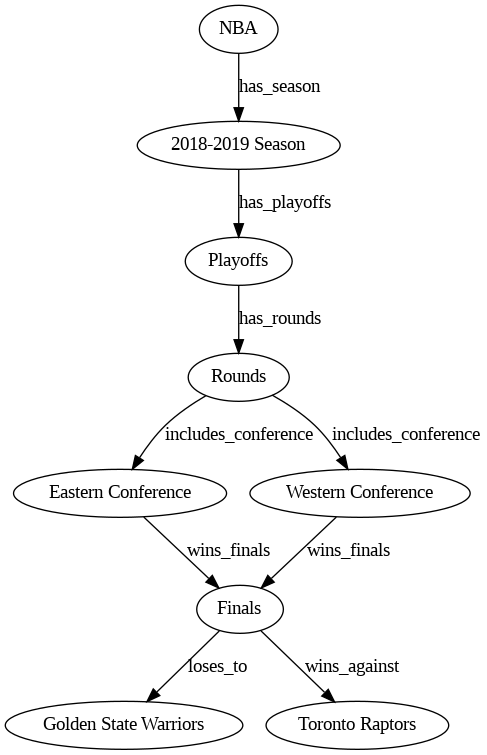

In [19]:
from IPython.display import Image, display

# Display the image of the knowledge graph
display(Image(filename='/content/knowledge_graph.png'))

We were able to get a LLM to generate a knowledge graph by telling is the structure that a knowledge graph library, GraphViz, expects the output to be in. We then used GraphViz to create and visualize the knowledge graph above!

Learn more about how to use JSON mode in the [docs](https://docs.together.ai/docs/json-mode) here!